# Landmark-based Registration

## Introduction
In this exercise, you will implement 3D rigid and affine image registration based on anatomical landmarks. You will work with a T1-weighted and a T2-weighted MRI scan of the same patient, where the patient is lying in a different position in the scanner between the two image acquisition (for the purpose of this exercise, the movement is simulated).

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and code hints
Import Python libraries:

In [1]:
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib ipympl
plt.ion()
import numpy as np
np.set_printoptions( suppress=True )
import nibabel as nib
import scipy
from scipy.ndimage import map_coordinates

Read the two 3D scans you'll be working with in this exercise:

In [2]:
# Load T1 and T2 data
T1_fileName = 'IXI014-HH-1236-T1.nii.gz'
T2_fileName = 'IXI014-HH-1236-T2_moved.nii.gz'
T1 = nib.load( T1_fileName )
T2 = nib.load( T2_fileName )
T1_data = T1.get_fdata()
T2_data = T2.get_fdata()

Below is code to define a simple interactive viewer class that can be used to visualize 2D cross-sections of a 3D array along three orthogonal directions. It takes a 3D volume as input and shows the location a "linked cursor" in all three cross-sections.

In [3]:
class Viewer:
    def __init__(self, data ):
        self.fig, self.ax = plt.subplots()
        self.data = data
        self.dims = self.data.shape
        self.position = np.round( np.array( self.dims ) / 2 ).astype( int )
        self.draw()
        self.fig.canvas.mpl_connect( 'button_press_event', self )
        self.fig.show()

    def __call__(self, event):
        print( 'button pressed' )
        if event.inaxes is None: return
      
        x, y = round( event.xdata ), round( event.ydata )

        #
        if ( x > (self.dims[0]-1) ) and ( y <= (self.dims[1]-1) ): return # lower-right quadrant
          
        #
        if x < self.dims[0]:
          self.position[ 0 ] = x
        else:
          self.position[ 1 ] = x - self.dims[0]
        
        if y < self.dims[1]:
          self.position[ 1 ] = y
        else:
          self.position[ 2 ] = y -self.dims[1]
        
        print( f"  voxel index: {self.position}" )
        print( f"  intensity: {self.data[ self.position[0], self.position[1], self.position[2] ]}" )

        self.draw()

    def draw( self ):
        #
        # Layout on screen is like this:
        #
        #     ^            ^
        #  Z  |         Z  |
        #     |            |
        #     ----->        ---->  
        #       X             Y
        #     ^
        #  Y  |
        #     |
        #     ----->  
        #       X
        #
        dims = self.dims
        position = self.position
        
        xySlice = self.data[ :, :, position[ 2 ] ]
        xzSlice = self.data[ :, position[ 1 ], : ]
        yzSlice = self.data[ position[ 0 ], :, : ]
        
        kwargs = dict( vmin=self.data.min(), vmax=self.data.max(), 
                       origin='lower', 
                       cmap='gray',
                       picker=True )

        self.ax.clear()

        self.ax.imshow( xySlice.T, 
                        extent=( 0, dims[0]-1, 
                                 0, dims[1]-1 ), 
                        **kwargs )
        self.ax.imshow( xzSlice.T, 
                        extent=( 0, dims[0]-1, 
                                 dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )
        self.ax.imshow( yzSlice.T, extent=( dims[0], dims[0]+dims[1]-1, 
                                            dims[1], dims[1]+dims[2]-1 ), 
                        **kwargs )

        color = 'g'
        self.ax.plot( (0, dims[0]-1), (position[1], position[1]), color )
        self.ax.plot( (0, dims[0]+dims[1]-1), (dims[1]+position[2], dims[1]+position[2]), color )
        self.ax.plot( (position[0], position[0]), (0, dims[1]+dims[2]-1), color )
        self.ax.plot( (dims[0]+position[1], dims[0]+position[1]), (dims[1]+1, dims[1]+dims[2]-1), color )

        self.ax.set( xlim=(1, dims[0]+dims[1]), ylim=(0, dims[1]+dims[2]) )

        self.ax.text( dims[0] + dims[1]/2, dims[1]/2, 
                      f"voxel index: {position}",  
                      horizontalalignment='center', verticalalignment='center' )
  
        self.ax.axis( False )

        self.fig.canvas.draw()

The code below shows how to visualize the T1-weigthed and the T2-weighted volumes with this viewer class. The initial location of the cursor is in the middle of the volume in each case. It can be changed by clicking on one of the cross-sections. The viewer also displays the voxel index $\mathbf{v}$ of the cursor. Play around and try to understand what the Viewer() class does.

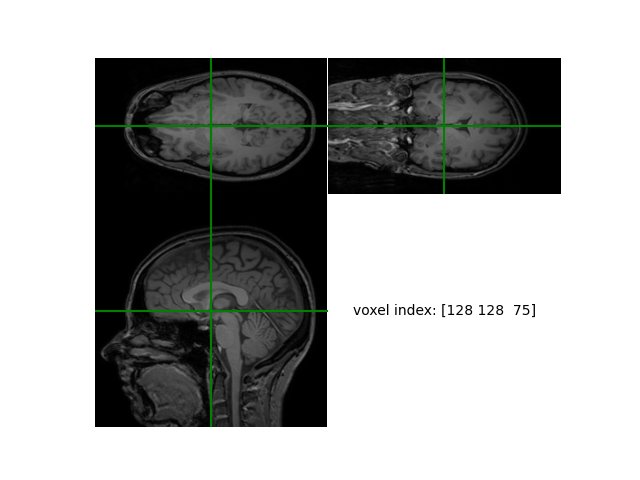

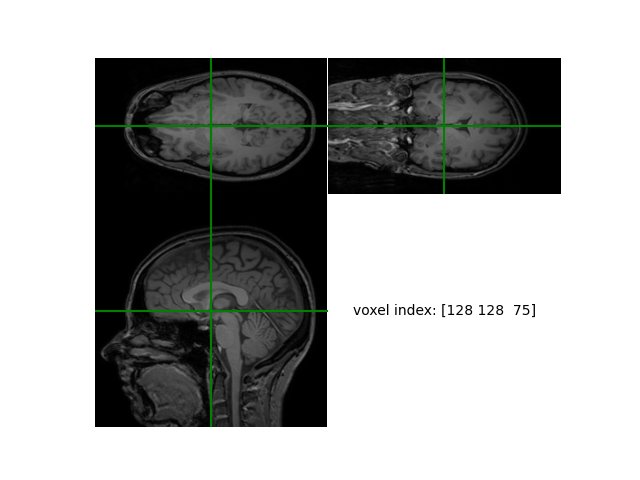

In [4]:
T1_viewer = Viewer( T1_data )

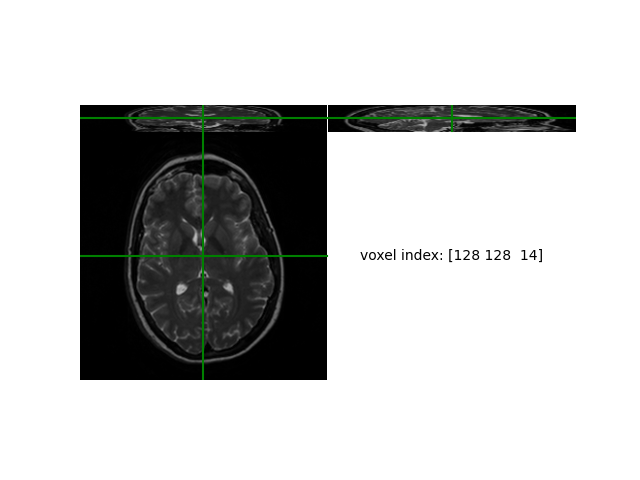

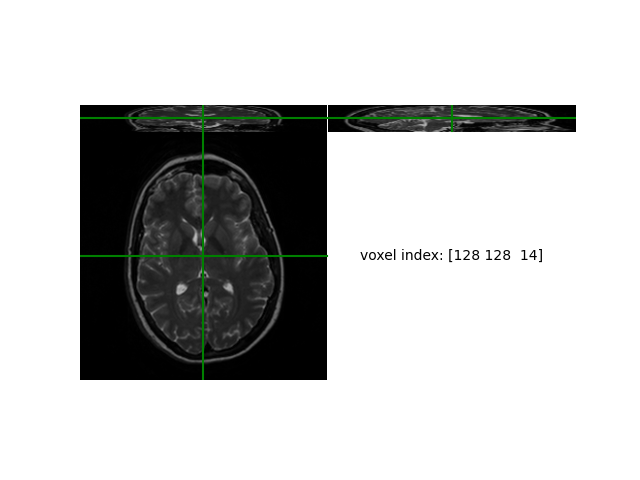

In [5]:
T2_viewer = Viewer( T2_data )

### Task 1: Coordinate Systems

Familiarize yourself with the concept of coordinate systems. In your report, explain why we need to differentiate between "voxel coordinates/indices" $\mathbf{v}$ and "world coordinates" $\mathbf{x}$. Why does the T2-weighted volume look so compressed in the viewer? For the enthusiastic student: calculate the voxel size in each dataset.

The world coordinate system used in both the T1-weighted and the T2-weighted scan follows the RAS convention. Equipped with this information, determine the voxel index $\mathbf{v}$ of the center of the left eye of the patient in the T1-weighted scan. Do the same for the T2-weighted scan.
 
> ***Hints:***
> 
> - The affine voxel-to-world matrix of the T1-weighted scan is given by
>
>        T1.affine
>
> 
> - In nibabel, the RAS convention is used (see bottom of https://nipy.org/nibabel/coordinate_systems.html)



In [6]:

T1_x = np.array([63, 113, 53, 1])
T2_x = np.array([151, 202, 9, 1])

print("size of zdim in T1:", T1.shape[2])
print("size of zdim in T2:", T2.shape[2])

M_1 = T1.affine
M_2 = T2.affine
y_t1 = M_1 @ T1_x
y_t2 = M_2 @ T2_x

print("The affine transformation to real coordinates T1:", y_t1)
print("The affine transformation to real coordinates T2:", y_t2)

size of zdim in T1: 150
size of zdim in T2: 28
The affine transformation to real coordinates T1: [-27.14145217  74.32765178  -7.8879905    1.        ]
The affine transformation to real coordinates T2: [-17.79412344 106.27771614 -28.30832504   1.        ]


Acording to the RAS the left eye should have a negative **x1**, this is true for T1 but not T2. Therefor we flip the first coordinate.
We change T2_x = np.array([90, 202, 9, 1]) to T2_x = np.array([151, 202, 9, 1])

### Task 2: Resample the T2-weighted scan to the image grid of the T1-weighted scan

In this task you should resample the T2-weighted scan to the image grid of the T1-weighted scan, i.e., create a new 3D volume that has the same size as the T1-weighted volume, but that contains interpolated T2-weighted intensities instead. In particular, for each voxel index $\mathbf{v}_{T1}$ in the T1-weighted image grid, you should compute the corresponding voxel index $\mathbf{v}_{T2}$ in the T2-weighted volume as follows (see section 2.1 in the book):
$$
\begin{pmatrix} \mathbf{ v_{T2}} \\ 1 \end{pmatrix} = \mathbf{M}_{T2}^{-1} \cdot \mathbf{M}_{T1} \cdot \begin{pmatrix} \mathbf{ v_{T1}} \\ 1 \end{pmatrix}
.
$$
At the location $\mathbf{v}_{T2}$, you should then use cubic B-spline interpolation to determine the intensity in the T2-weighted scan, and store it at index $\mathbf{v}_{T1}$ in the newly created image.

Once you have created a new volume like this, visualize it overlaid on the T1-weighted volume as follows:
    
    Viewer( T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max() )

> ***Hints:***
> - you can create a coordinate grid in 3D with the function
> 
>        V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), 
>                                np.arange( T1_data.shape[1] ), 
>                                np.arange( T1_data.shape[2] ), indexing='ij' )
>   
>
> - the following SciPy function interpolates the T2-weighted volume at voxel coordinates $(1.1,2.2,3.3)^T$ 
> and $(6.6,7.7,8.8)^T$ using cubic interpolation:   
>
>        scipy.ndimage.map_coordinates( T2_data, np.array( [ [1.1,2.2,3.3], [6.6,7.7,8.8] ] ).T )
>

(4, 9830400)


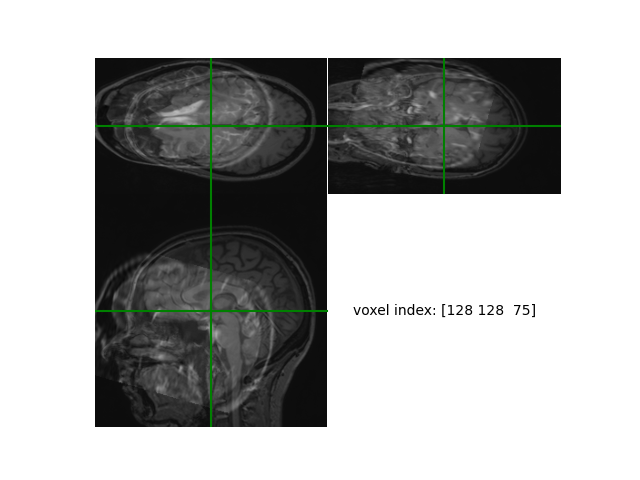

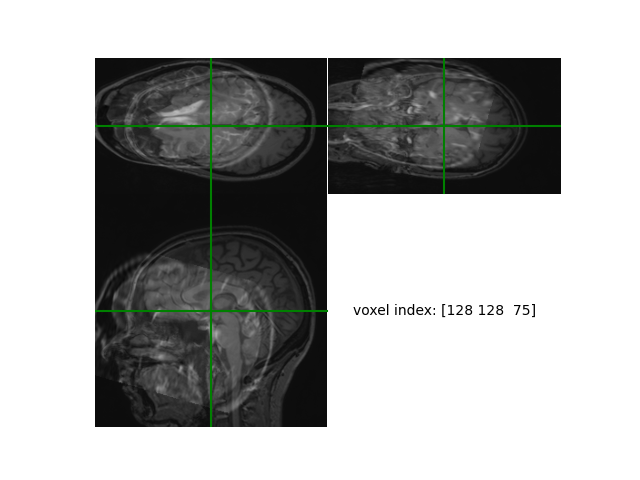

In [7]:
V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), 
                                np.arange( T1_data.shape[1] ), 
                                np.arange( T1_data.shape[2] ), indexing='ij' )
V1, V2, V3 = V1.flatten(), V2.flatten(), V3.flatten() 
V_T1 = np.column_stack([V1, V2, V3, np.ones(len(V3))])
V_T1 = V_T1.T

V_T2_space = np.linalg.solve(M_2, M_1@V_T1)
print(V_T2_space.shape)

T2_inter = map_coordinates(T2_data, V_T2_space[:3,:], order = 3)
T2_data_resampled = T2_inter.reshape(T1_data.shape)
Viewer(T2_data_resampled / T2_data_resampled.max() + T1_data / T1_data.max())



### Task 3: Collect corresponding landmarks

Using the viewer class, record the voxel coordinates $\mathbf{v_{T1}}$ and $\mathbf{v_{T2}}$ of at least five corresponding landmarks in the T1- and the T2-weighted volumes, respectively. List them in your report, and explain why you picked them. 

> ***Hint:***
> - Avoid picking landmarks that are very close to each other or that all lie approximately in the same 2D plane.
> - You can double-check which landmarks you've selected as follows:
>         T1_viewer = Viewer( T1_data )
>         T1_viewer.position = ( 20, 30, 40 )
>         T1_viewer.draw()
> 


In [9]:
## 4 pairwise landmarks 
LM_t1 = np.vstack([
    [37, 110, 79, 1],    # Nose ridge
    [240, 110, 78, 1],   # Back skull
    [144, 110, 131, 1],  # Right side skull
    [144, 110, 20, 1],   # Left side skull
    [144, 198, 75, 1]   # Top of brain/skull
])

LM_t2 = np.vstack([
    [125, 231, 8, 1],    # Nose ridge
    [137, 20, 8, 1],     # Back skull
    [55, 116, 8, 1],     # Right side skull 
    [206, 116, 8, 1],    # left side skull
    [128, 116, 25, 1]    # Top of brain/skull
])

T1_world = (M_1 @ LM_t1.T).T[:, :3]
T2_world = (M_2 @ LM_t2.T).T[:, :3]

In [10]:
print("T1_world shape:", T1_world.shape)
print("T2_world shape:", T2_world.shape)

# Calculate X from eq 2.8
X = np.hstack([T1_world, np.ones((T1_world.shape[0], 1))])
print(X.T.shape, T2_world.shape)
A, _, _, _ = np.linalg.lstsq(X, T2_world, rcond=None)# Calculating best affine matrix fit

# full affine matrix
M = np.eye(4)
M[:3, :] = A.T
print("Shape of M:", M.shape)

T1_world shape: (5, 3)
T2_world shape: (5, 3)
(4, 5) (5, 3)
Shape of M: (4, 4)


### Task 4: Perform affine landmark-based registration 

Using the landmarks you recorded in the previous task, compute the parameters of the 3D affine transformation that brings the landmarks in the T1-weighted image closest to the corresponding ones in the T2-weighted image. For this purpose, use Equation (2.8) in the book.

Once you've determined the affine transformation, register to two images by resampling the T2-weighted image to the image grid of the T1-weighted image, and overlay the two images as in Task 2. To map voxel coordinates $\mathbf{v}_T1$ to $\mathbf{v}_T2$, you'll have to use 
$$
\begin{pmatrix} \mathbf{ v_{T2}} \\ 1 \end{pmatrix} = \mathbf{M}_{T2}^{-1} \cdot \mathbf{M} \cdot \mathbf{M}_{T1} \cdot \begin{pmatrix} \mathbf{ v_{T1}} \\ 1 \end{pmatrix}
,
$$
where $\mathbf{M}$ is your $4 \times 4$ affine matrix (see book).

What happens when you increase/decrease the number of corresponding landmarks that are used in the computations? Comment.

> ***Hint:***
> - remember that the affine matrix works in *world* coordinates, so you'll have to map your landmarks to world coordinates first.
> - you can use  
>
>       np.hstack() 
>
>   to append a column of ones to an existing matrix (e.g., to construct the $\mathbf{X}$ matrix in Equation (2.8) in the book).
>

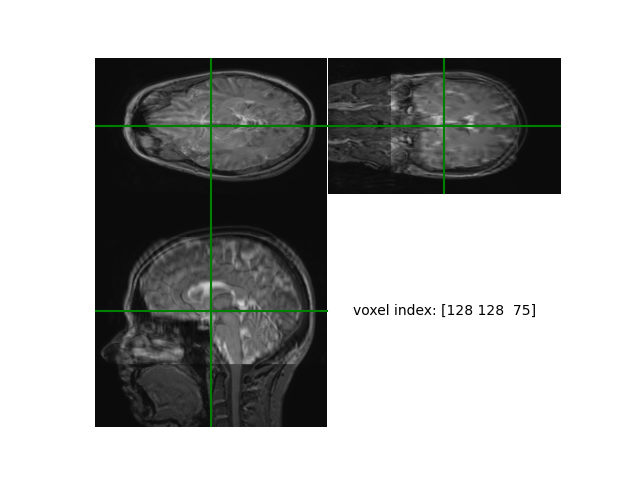

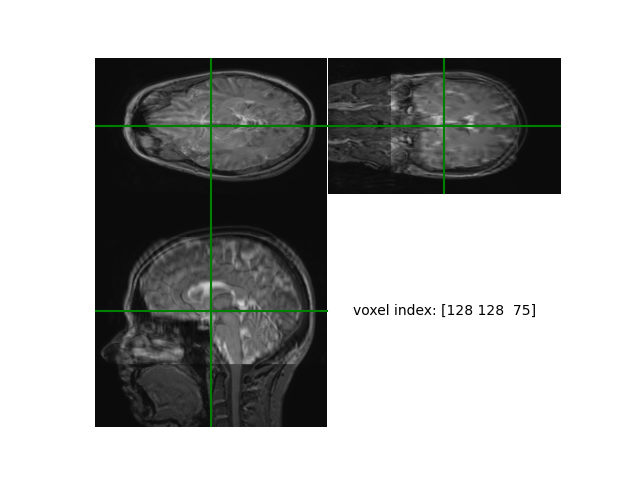

In [11]:
Big_M = np.linalg.solve(M_2, M @ M_1)
V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), 
                                np.arange( T1_data.shape[1] ), 
                                np.arange( T1_data.shape[2] ), indexing='ij' )
V1, V2, V3 = V1.flatten(), V2.flatten(), V3.flatten() 
V_T1 = np.column_stack([V1, V2, V3, np.ones(len(V3))])
V_T1 = V_T1.T

T2_space = Big_M @ V_T1
T2_interpolated = map_coordinates(T2_data, T2_space[:3], order=3)
T2_moved = T2_interpolated.reshape(T1_data.shape)

Viewer(T2_moved / T2_moved.max() + T1_data / T1_data.max())


### Task 5: Perform rigid landmark-based registration 

Repeat Task 4, but this time using a *rigid* transformation model. Vary the number of landmarks that are used again, and comment. Which transformation model (affine or rigid) is more appropriate to use in this specific application?

> ***Hint:***
> - a singular value decomposition can be computed using
>           
>          np.linalg.svd()
>
> - the determinant of a matrix can be computed using
>    
>         np.linalg.det()
>


In [12]:
T1_world = (M_1 @ LM_t1.T).T [3:, :3] # 2x3
T2_world = (M_2 @ LM_t2.T).T [3:, :3] # 2x3
x_hat = T1_world.mean(axis=0)   
y_hat = T2_world.mean(axis=0)   
x_tilde = T1_world - x_hat
y_tilde = T2_world - y_hat
H = x_tilde.T @ y_tilde

print(H.shape)

U, S, V = np.linalg.svd(H)
R = V @ U.T # Makes sure determinate is det(R) = 1 and that V.T @ V,  U.T @U = I identity matrix
if np.linalg.det(R) < 0:
    V[-1, :] *= -1
    R = V.T @ U.T

print("det(R) =", np.linalg.det(R))    # should be ≈ +1
print("R^T R =", R.T @ R)
t = y_hat - R @ x_hat # eq 2.10 finding t

# create M Rotation R and t
M = np.eye(4)
M[:3, :3] = R
M[:3, 3]  = t

(3, 3)
det(R) = 0.9999999999999997
R^T R = [[ 1.  0. -0.]
 [ 0.  1. -0.]
 [-0. -0.  1.]]


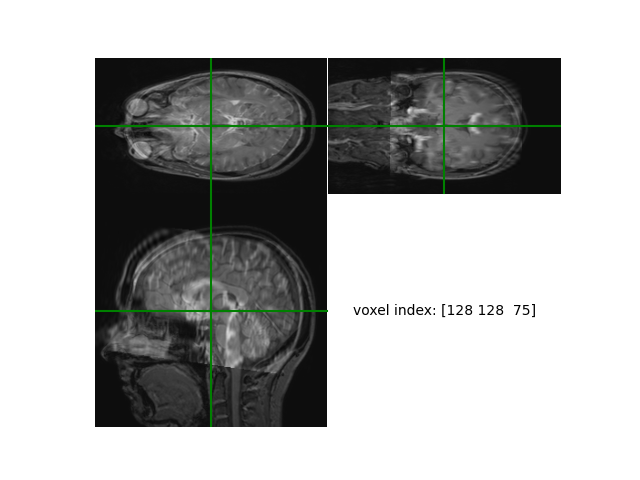

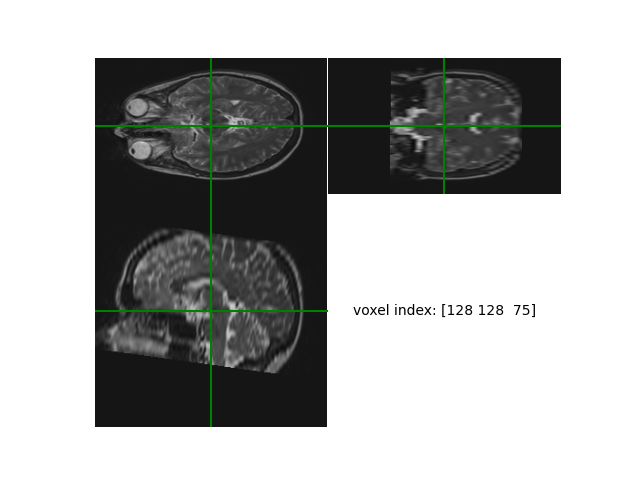

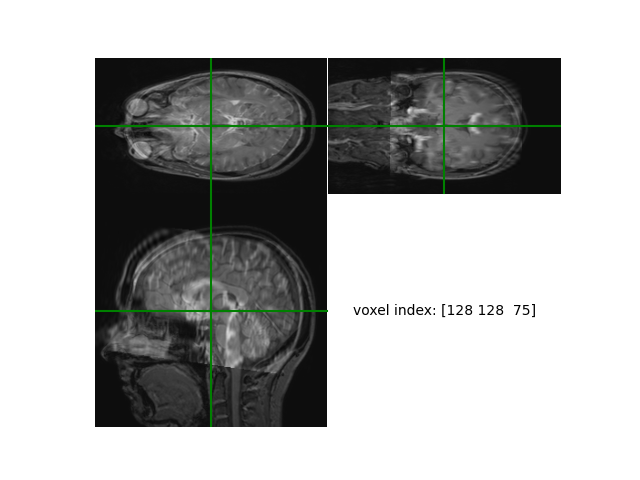

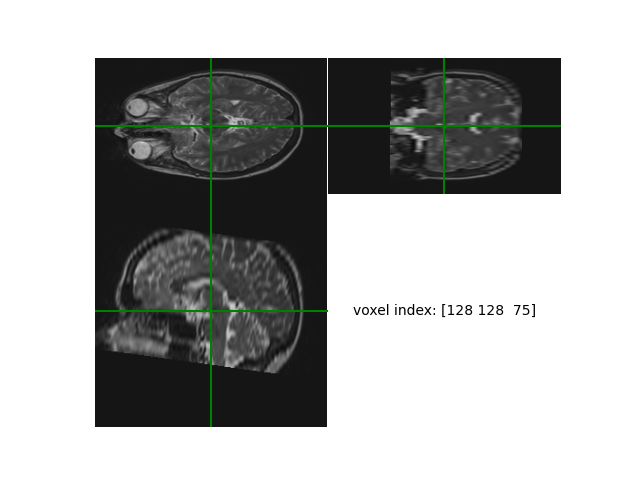

In [13]:
Big_M = np.linalg.solve(M_2, M @ M_1)

V1,V2,V3 = np.meshgrid( np.arange( T1_data.shape[0] ), 
                                np.arange( T1_data.shape[1] ), 
                                np.arange( T1_data.shape[2] ), indexing='ij' )
V1, V2, V3 = V1.flatten(), V2.flatten(), V3.flatten() 
V_T1 = np.column_stack([V1, V2, V3, np.ones(len(V3))])
V_T1 = V_T1.T

T2_space = Big_M @ V_T1 # Calculation T2_transformation to T1_space

# sample T2 image on these coordinates
T2_resampled = map_coordinates(T2_data, T2_space[:3], order=3)
T2_resampled = T2_resampled.reshape(T1_data.shape)

Viewer(T2_resampled / T2_resampled.max() + T1_data / T1_data.max())
Viewer(T2_resampled)
